In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/datasets/plant_disease.zip"
extract_path = "/content/datasets"

if not os.path.exists(extract_path):
    os.makedirs(extract_path)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully")


Dataset extracted successfully


In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import json

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPool2D, Dense, Dropout,
    GlobalAveragePooling2D, Rescaling,
    RandomFlip, RandomRotation, RandomZoom
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report


In [7]:
train_dir = "/content/datasets/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_dir = "/content/datasets/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"


In [8]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

training_set = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

class_names = training_set.class_names
num_classes = len(class_names)

print("Number of classes:", num_classes)


Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.
Number of classes: 38


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

training_set = training_set.prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.prefetch(buffer_size=AUTOTUNE)


In [10]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)
])


In [11]:
model = Sequential()

# Normalize images
model.add(Rescaling(1./255, input_shape=(128,128,3)))

# Augmentation
model.add(data_augmentation)

# Block 1
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPool2D(2,2))

# Block 2
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPool2D(2,2))

# Block 3
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPool2D(2,2))

# Block 4
model.add(Conv2D(256, 3, padding='same', activation='relu'))
model.add(Conv2D(256, 3, activation='relu'))
model.add(MaxPool2D(2,2))

# Global Average Pooling
model.add(GlobalAveragePooling2D())

# Dense Layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Output
model.add(Dense(num_classes, activation='softmax'))

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,323,334 (5.05 MB)

 Trainable params: 1,323,334 (5.05 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [13]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
]

In [14]:
EPOCHS = 30

history = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 135s 58ms/step - accuracy: 0.1424 - loss: 3.0893 - val_accuracy: 0.4865 - val_loss: 1.7240 - learning_rate: 1.0000e-04
Epoch 2/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 131s 60ms/step - accuracy: 0.4868 - loss: 1.7066 - val_accuracy: 0.6214 - val_loss: 1.2632 - learning_rate: 1.0000e-04
Epoch 3/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 124s 56ms/step - accuracy: 0.6216 - loss: 1.2240 - val_accuracy: 0.7231 - val_loss: 0.8995 - learning_rate: 1.0000e-04
Epoch 4/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 131s 60ms/step - accuracy: 0.7201 - loss: 0.9008 - val_accuracy: 0.8001 - val_loss: 0.6423 - learning_rate: 1.0000e-04
Epoch 5/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 132s 60ms/step - accuracy: 0.7833 - loss: 0.6970 - val_accuracy: 0.8256 - val_loss: 0.5553 - learning_rate: 1.0000e-04
Epoch 6/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 123s 56ms/step - accuracy: 0.8243 - loss: 0.5538 - val_accuracy: 0.8155 - val_loss: 0.6098 - learning_rate: 1.0000e-04
Epoch 7/30
2197/2197 ━━━━━━━━━━━━━

In [15]:
train_loss, train_acc = model.evaluate(training_set)
val_loss, val_acc = model.evaluate(validation_set)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 50s 23ms/step - accuracy: 0.9711 - loss: 0.0848
550/550 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.9654 - loss: 0.1062
Training Accuracy: 0.9716
Validation Accuracy: 0.9631


In [25]:
model.save("/content/drive/MyDrive/models/plant_disease_cnn.keras")

with open("/content/drive/MyDrive/models/training_history.json", "w") as f:
    json.dump(history.history, f)

print("Model & history saved to Drive")

Model & history saved to Drive


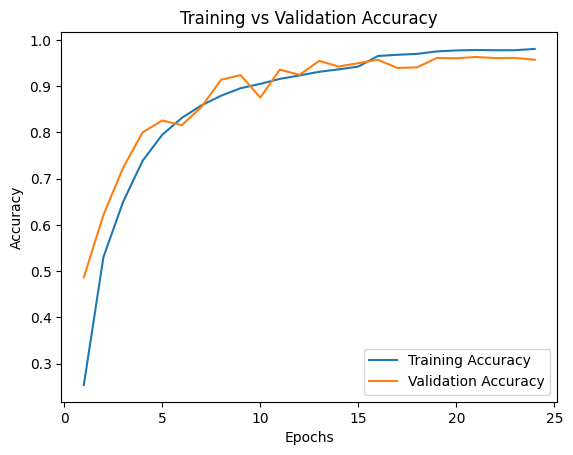

In [22]:
epochs = range(1, len(history.history['accuracy']) + 1)

plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

In [23]:
test_set = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

y_pred = model.predict(test_set)
y_pred_classes = tf.argmax(y_pred, axis=1)

y_true = tf.concat([y for x, y in test_set], axis=0)
y_true_classes = tf.argmax(y_true, axis=1)

print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=class_names
))

Found 17572 files belonging to 38 classes.
550/550 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.94      0.96       504
                                 Apple___Black_rot       0.98      0.97      0.97       497
                          Apple___Cedar_apple_rust       1.00      0.95      0.97       440
                                   Apple___healthy       0.99      0.85      0.92       502
                               Blueberry___healthy       0.98      0.99      0.98       454
          Cherry_(including_sour)___Powdery_mildew       0.97      0.99      0.98       421
                 Cherry_(including_sour)___healthy       0.97      1.00      0.98       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.91      0.97      0.94       410
                       Corn_(maize)___Common_rust_       0.99      0.98      0.99    

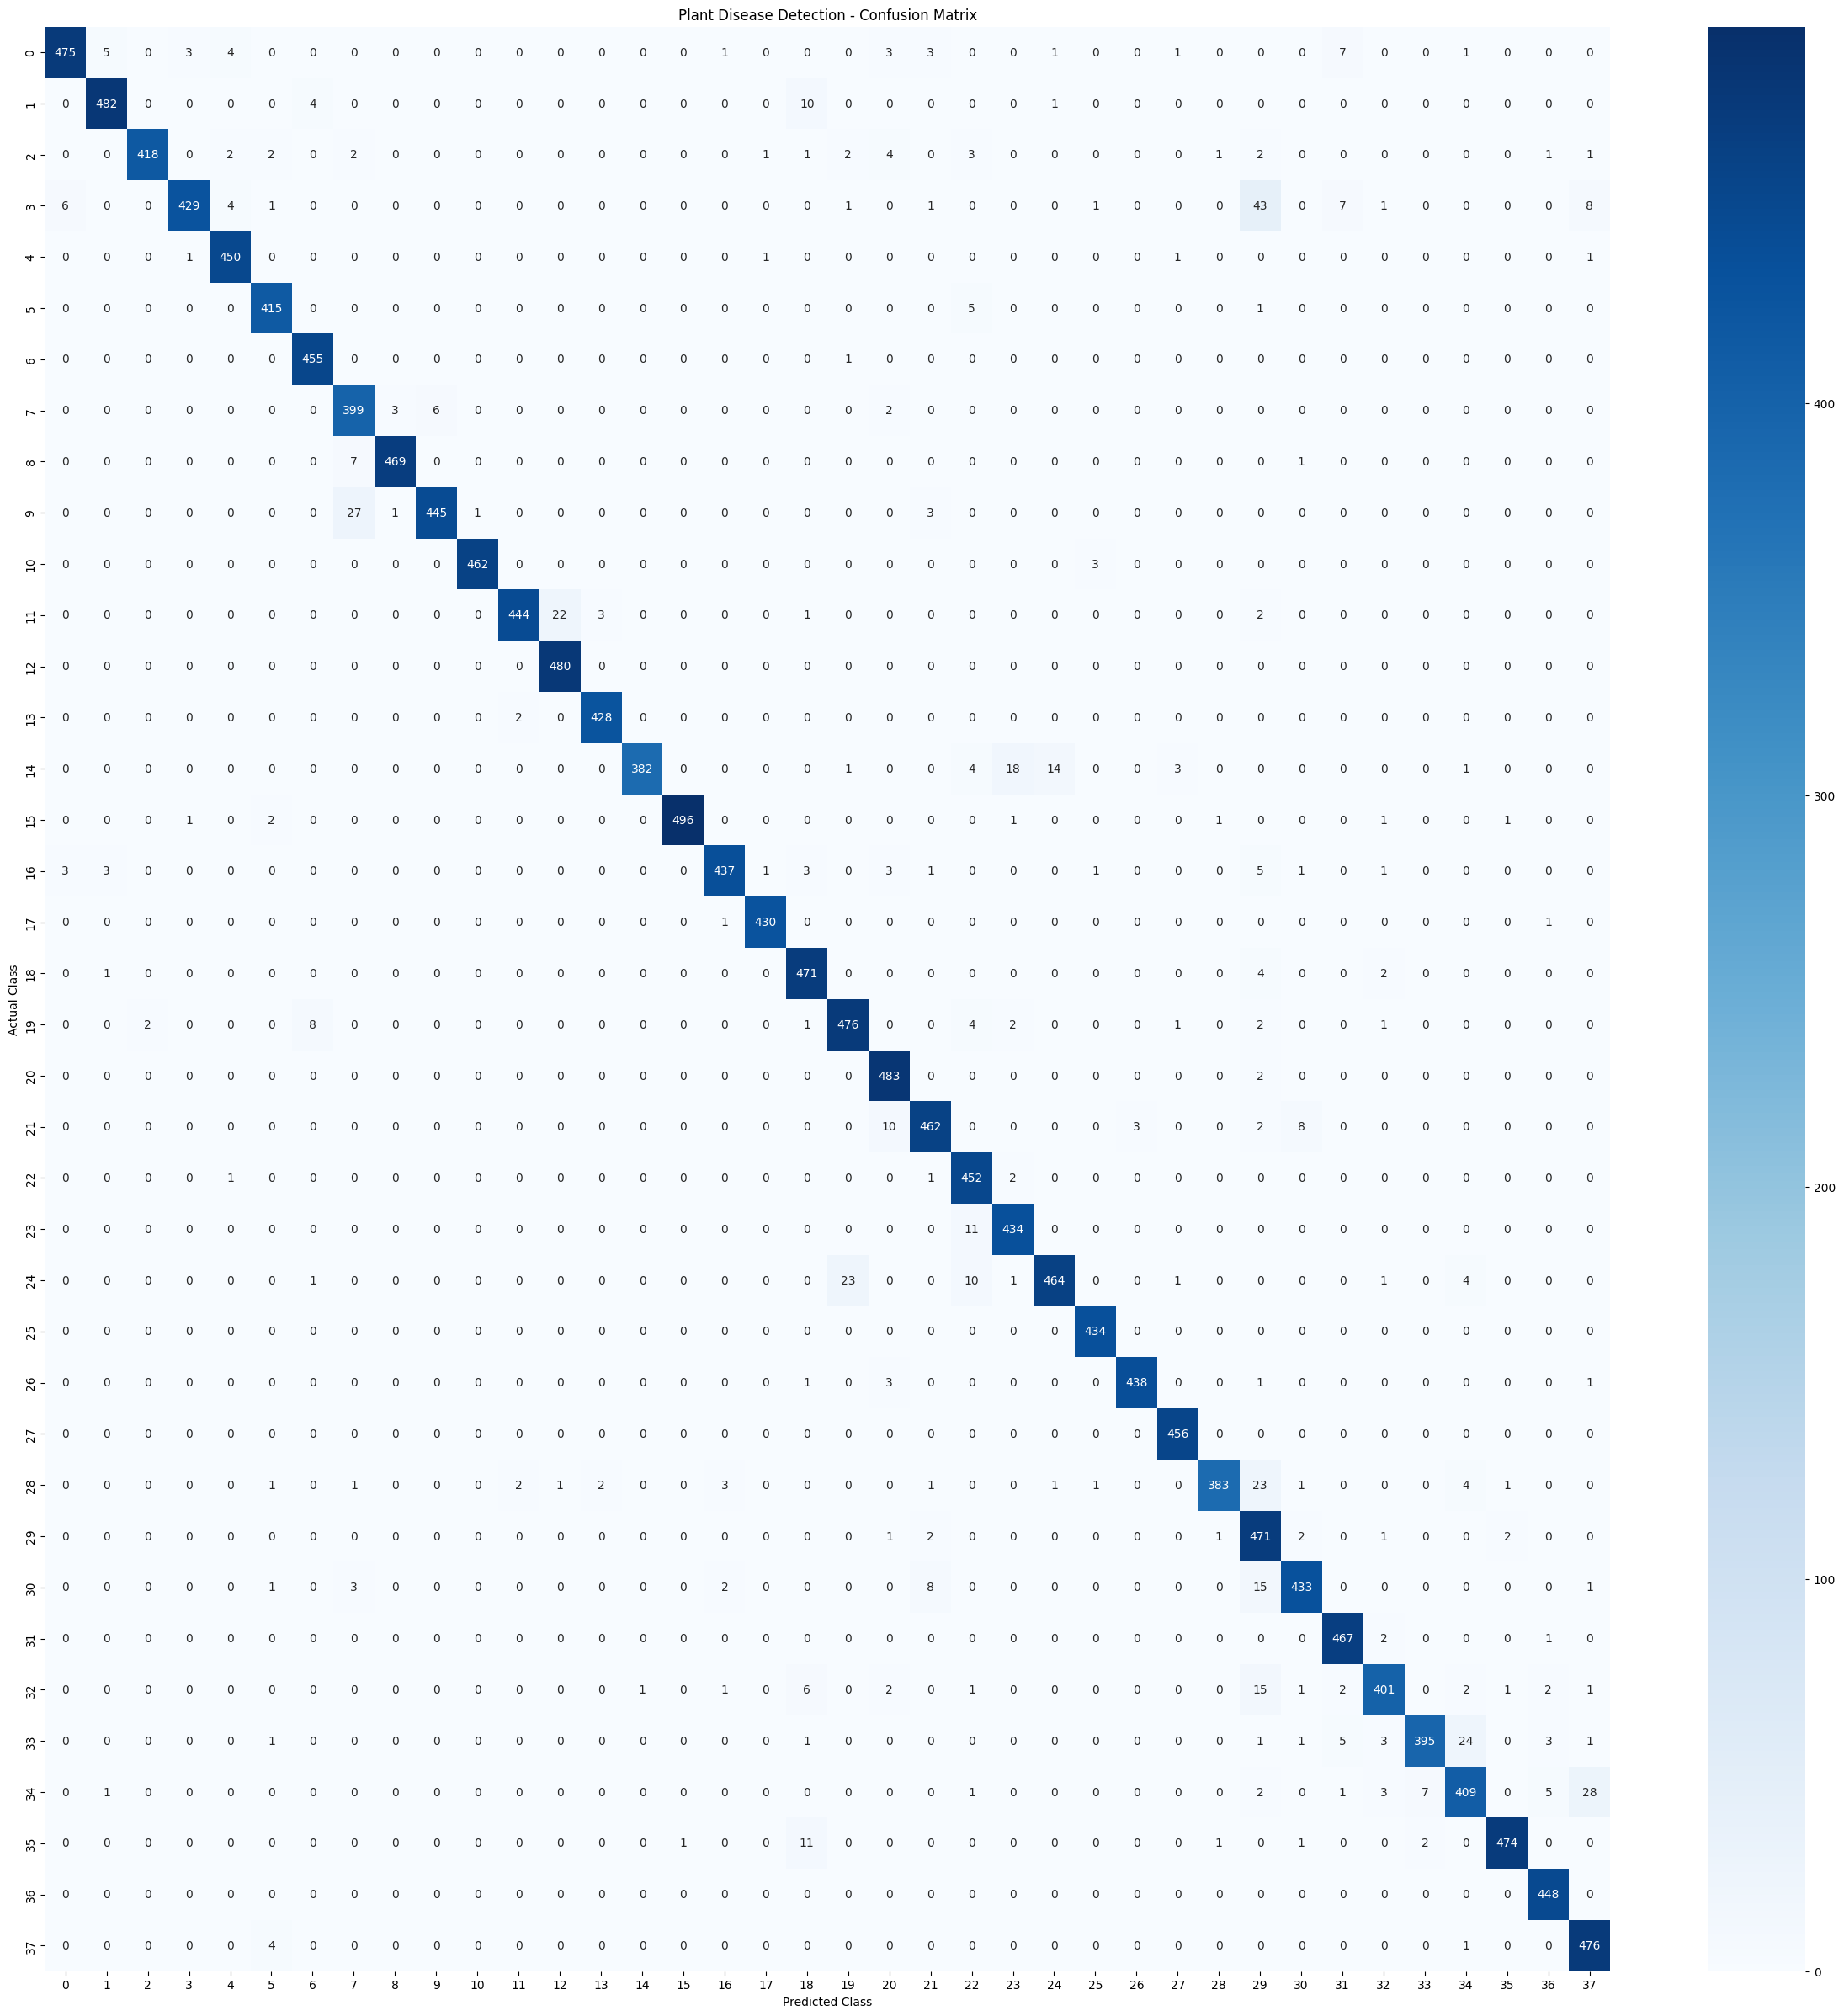

In [24]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Plant Disease Detection - Confusion Matrix")
plt.show()